### Group Prject - London Bike Rentals

In this project, you will work with the London Bikes dataset, which records daily bike rentals in the city along with key variables such as dates, weather conditions, and seasonality.

The goal is to apply the full data analytics workflow:

- Clean and prepare the dataset.

- Explore the data through visualisation.

- Construct and interpret confidence intervals.

- Build a regression model to explain variation in bike rentals.

- By the end, you will connect statistical concepts with practical Python analysis.

In [1]:
%pip install pandas numpy matplotlib seaborn scipy statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
## Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf

In [3]:
#import data
bikes = pd.read_csv('Data/london_bikes.csv')
bikes.head()

,date,bikes_hired,year,wday,month,week,cloud_cover,humidity,pressure,radiation,precipitation,snow_depth,sunshine,mean_temp,min_temp,max_temp,weekend
0,2010-07-30T00:00:00Z,6897,2010,Fri,Jul,30,6.0,65.0,10147.0,157.0,22.0,NaN,31.0,17.7,12.3,25.1,False
1,2010-07-31T00:00:00Z,5564,2010,Sat,Jul,30,5.0,70.0,10116.0,184.0,0.0,NaN,47.0,21.1,17.0,23.9,True
2,2010-08-01T00:00:00Z,4303,2010,Sun,Aug,30,7.0,63.0,10132.0,89.0,0.0,NaN,3.0,19.3,14.6,23.4,True
3,2010-08-02T00:00:00Z,6642,2010,Mon,Aug,31,7.0,59.0,10168.0,134.0,0.0,NaN,20.0,19.5,15.6,23.6,False
4,2010-08-03T00:00:00Z,7966,2010,Tue,Aug,31,5.0,66.0,10157.0,169.0,0.0,NaN,39.0,17.9,12.1,20.1,False


**1. Data Cleaning**

Check for missing values across columns. How would you handle them?

Inspect the date column and ensure it is correctly formatted as datetime. Extract useful features (year, month, day, day of week, season).

Convert categorical variables (e.g., season, weather) to appropriate categories in Python.

Ensure numeric columns (e.g., bikes rented, temperature) are in the right format.

In [4]:
#inspect column types
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4934 entries, 0 to 4933
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4934 non-null   object 
 1   bikes_hired    4934 non-null   int64  
 2   year           4934 non-null   int64  
 3   wday           4934 non-null   object 
 4   month          4934 non-null   object 
 5   week           4934 non-null   int64  
 6   cloud_cover    4901 non-null   float64
 7   humidity       4851 non-null   float64
 8   pressure       4903 non-null   float64
 9   radiation      4894 non-null   float64
 10  precipitation  4903 non-null   float64
 11  snow_depth     4632 non-null   float64
 12  sunshine       4903 non-null   float64
 13  mean_temp      4903 non-null   float64
 14  min_temp       4872 non-null   float64
 15  max_temp       4903 non-null   float64
 16  weekend        4934 non-null   bool   
dtypes: bool(1), float64(10), int64(3), object(3)
memory 

In [5]:
#convert date column to datetime format
bikes["date"] = pd.to_datetime(
    bikes["date"],
    format="%Y-%m-%dT%H:%M:%SZ",
    errors="coerce",
    utc=True
)

In [6]:
#Convert Months into sorted category
bikes["month"] = pd.Categorical(
    bikes["date"].dt.month_name(),
    categories=[
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ],
    ordered=True
)

In [7]:
#This is where we checked on the null values
bikes.isna().sum()

#we identified quite some null values in the following columns
#cloud_cover, humidity, pressure, radiation, precipitation, snow_depth, sunshine, mean_temp, min_temp, max_temp
#not all columns necessarily indicate lack of data - some null values like in snow depth might represent 0 
#however when data on temperature is lacking, we can interpret that these values actually are incomplete

date               0
bikes_hired        0
year               0
wday               0
month              0
week               0
cloud_cover       33
humidity          83
pressure          31
radiation         40
precipitation     31
snow_depth       302
sunshine          31
mean_temp         31
min_temp          62
max_temp          31
weekend            0
dtype: int64

In [8]:
#We suggest dropping the na values in humidity, pressure, radiation, mean_temp, min_temp, max_temp completely
#Then we want to substitute the other values with 0

drop_na_subset = ["humidity", "pressure", "radiation", 
                "mean_temp", "min_temp", "max_temp"]
fill_zero_subset = ["cloud_cover", "precipitation", 
                  "snow_depth", "sunshine"]

bikes = bikes.dropna(subset=drop_na_subset)
bikes[fill_zero_subset] = bikes[fill_zero_subset].fillna(0)

In [9]:
#Extract season based on month (northern hemisphere in London)
conditions = [
    bikes["date"].dt.month.isin([12, 1, 2]),
    bikes["date"].dt.month.isin([3, 4, 5]),
    bikes["date"].dt.month.isin([6, 7, 8]),
    bikes["date"].dt.month.isin([9, 10, 11]),
]
choices = ["Winter", "Spring", "Summer", "Autumn"]
bikes["season"] = np.select(conditions, choices, default = 'Unknown')
bikes["season"] = pd.Categorical(
    bikes["season"],
    categories=["Winter", "Spring", "Summer", "Autumn"],
    ordered=True
)
bikes.head()

,date,bikes_hired,year,wday,month,week,cloud_cover,humidity,pressure,radiation,precipitation,snow_depth,sunshine,mean_temp,min_temp,max_temp,weekend,season
0,2010-07-30 00:00:00+00:00,6897,2010,Fri,July,30,6.0,65.0,10147.0,157.0,22.0,0.0,31.0,17.7,12.3,25.1,False,Summer
1,2010-07-31 00:00:00+00:00,5564,2010,Sat,July,30,5.0,70.0,10116.0,184.0,0.0,0.0,47.0,21.1,17.0,23.9,True,Summer
2,2010-08-01 00:00:00+00:00,4303,2010,Sun,August,30,7.0,63.0,10132.0,89.0,0.0,0.0,3.0,19.3,14.6,23.4,True,Summer
3,2010-08-02 00:00:00+00:00,6642,2010,Mon,August,31,7.0,59.0,10168.0,134.0,0.0,0.0,20.0,19.5,15.6,23.6,False,Summer
4,2010-08-03 00:00:00+00:00,7966,2010,Tue,August,31,5.0,66.0,10157.0,169.0,0.0,0.0,39.0,17.9,12.1,20.1,False,Summer


**2. Exploratory Data Analysis (EDA)**

Plot the distribution of bikes rented.

Explore how rentals vary by season and month.

Investigate the relationship between temperature and bikes rented.

**Deliverables:**

At least 3 clear visualisations with captions.

A short written interpretation of key patterns (seasonality, weather effects, etc.).



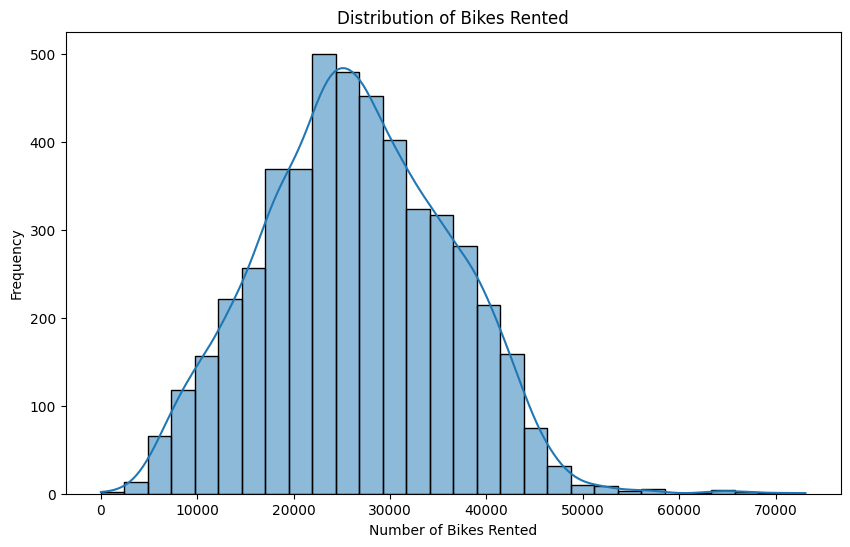

,date,bikes_hired,year,wday,month,week,cloud_cover,humidity,pressure,radiation,precipitation,snow_depth,sunshine,mean_temp,min_temp,max_temp,weekend,season
0,2010-07-30 00:00:00+00:00,6897,2010,Fri,July,30,6.0,65.0,10147.0,157.0,22.0,0.0,31.0,17.7,12.3,25.1,False,Summer
1,2010-07-31 00:00:00+00:00,5564,2010,Sat,July,30,5.0,70.0,10116.0,184.0,0.0,0.0,47.0,21.1,17.0,23.9,True,Summer
2,2010-08-01 00:00:00+00:00,4303,2010,Sun,August,30,7.0,63.0,10132.0,89.0,0.0,0.0,3.0,19.3,14.6,23.4,True,Summer
3,2010-08-02 00:00:00+00:00,6642,2010,Mon,August,31,7.0,59.0,10168.0,134.0,0.0,0.0,20.0,19.5,15.6,23.6,False,Summer
4,2010-08-03 00:00:00+00:00,7966,2010,Tue,August,31,5.0,66.0,10157.0,169.0,0.0,0.0,39.0,17.9,12.1,20.1,False,Summer


In [10]:
#plot distribution of bikes rented
plt.figure(figsize=(10, 6))
sns.histplot(bikes['bikes_hired'], bins=30, kde=True)
plt.title('Distribution of Bikes Rented')
plt.xlabel('Number of Bikes Rented')
plt.ylabel('Frequency')
plt.show()

bikes.head()

C:\Users\balazs.szabo\AppData\Local\Temp\ipykernel_37808\2045757956.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='season', y='bikes_hired', data=bikes, palette='Set2')


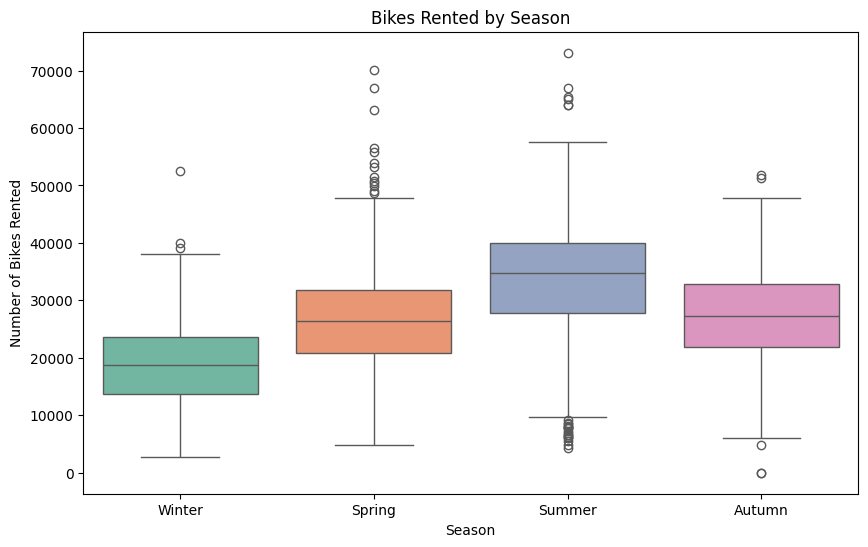

In [11]:
#explore how bikes rented varies by season
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='bikes_hired', data=bikes, palette='Set2')
plt.title('Bikes Rented by Season')
plt.xlabel('Season')
plt.ylabel('Number of Bikes Rented')
plt.show()

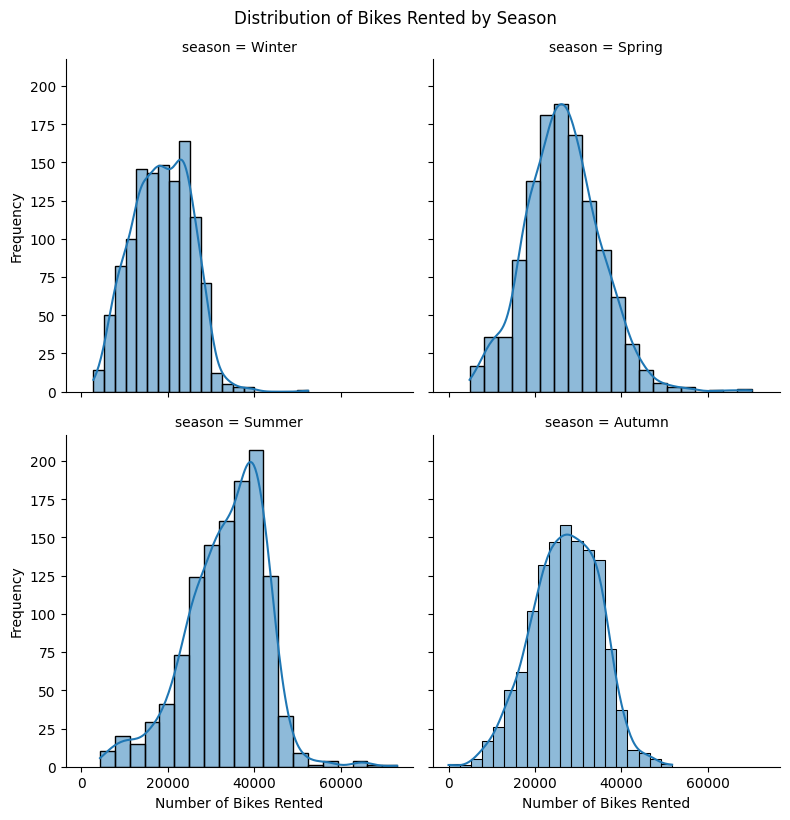

In [12]:
#histograms of bikes rented by season
g = sns.FacetGrid(bikes, col="season", col_wrap=2, height=4)
g.map(sns.histplot, "bikes_hired", bins=20, kde=True)
g.set_axis_labels("Number of Bikes Rented", "Frequency")
g.fig.suptitle('Distribution of Bikes Rented by Season', y=1.02)
plt.show()  

C:\Users\balazs.szabo\AppData\Local\Temp\ipykernel_37808\4084301565.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bikes.groupby(bikes["month"])


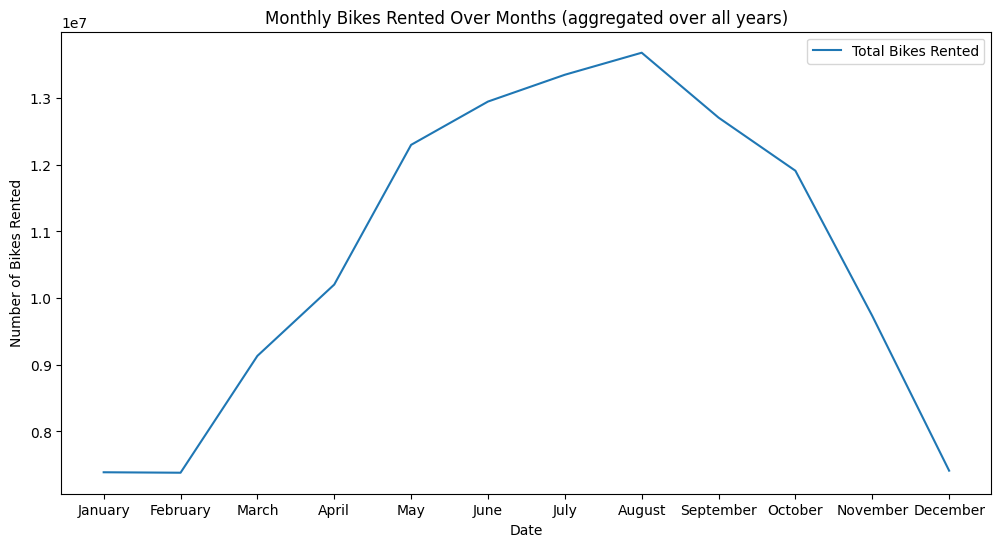

In [13]:
#lineplot of the sum and mean of bikes rented for each month over all years
bikes_monthly = (
    bikes.groupby(bikes["month"])
            .agg(total_bikes_rented=("bikes_hired", "sum"))
            .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=bikes_monthly, x="month", y="total_bikes_rented", label="Total Bikes Rented")
plt.title("Monthly Bikes Rented Over Months (aggregated over all years)")
plt.xlabel("Date")
plt.ylabel("Number of Bikes Rented")
plt.legend()
plt.show()

**3. Construct 95% confidence intervals for the mean number of bikes rented per season.**

Repeat the calculation per month.

Interpret the result:

What range of values do you expect the true mean to lie in?

Which seasons/months have higher or lower average demand?

Are there overlaps in the intervals, and what does that mean?

**Deliverables:**

A table or plot showing the mean and confidence intervals.

A short interpretation.

In [14]:
# Confidence Interval (CI) using the formula mean +- t_critical * SE

# Group by genre and calculate statistics
month_formula_ci = (
    bikes
    .groupby('season')
    .agg(
        mean_rating=('bikes_hired', 'mean'),
        median_rating=('bikes_hired', 'median'),
        sd_rating=('bikes_hired', 'std'),
        count=('bikes_hired', 'size')
    )
    .reset_index()
)

# Calculate additional statistics for confidence intervals
month_formula_ci['t_critical'] = month_formula_ci['count'].apply(lambda n: stats.t.ppf(0.975, df=n-1))  # t-critical value
month_formula_ci['se_rating'] = month_formula_ci['sd_rating'] / np.sqrt(month_formula_ci['count'])  # Standard error
month_formula_ci['margin_of_error'] = month_formula_ci['t_critical'] * month_formula_ci['se_rating']  # Margin of error
month_formula_ci['rating_low'] = month_formula_ci['mean_rating'] - month_formula_ci['margin_of_error']  # Lower bound
month_formula_ci['rating_high'] = month_formula_ci['mean_rating'] + month_formula_ci['margin_of_error']  # Upper bound

# Sort by mean rating in descending order
month_formula_ci = month_formula_ci.sort_values(by='mean_rating', ascending=False)

# Display the result
month_formula_ci

C:\Users\balazs.szabo\AppData\Local\Temp\ipykernel_37808\4167191430.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('season')


,season,mean_rating,median_rating,sd_rating,count,t_critical,se_rating,margin_of_error,rating_low,rating_high
2,Summer,33595.457983,34738.0,9156.356507,1190,1.961961,265.429515,520.762400,33074.695583,34116.220383
3,Autumn,27090.992114,27359.5,7817.950352,1268,1.961838,219.549919,430.721395,26660.270718,27521.713509
1,Spring,26585.562185,26425.5,8655.554728,1190,1.961961,250.911996,492.279593,26093.282592,27077.841778
0,Winter,18578.608878,18678.0,6675.942161,1194,1.961954,193.201459,379.052465,18199.556413,18957.661342


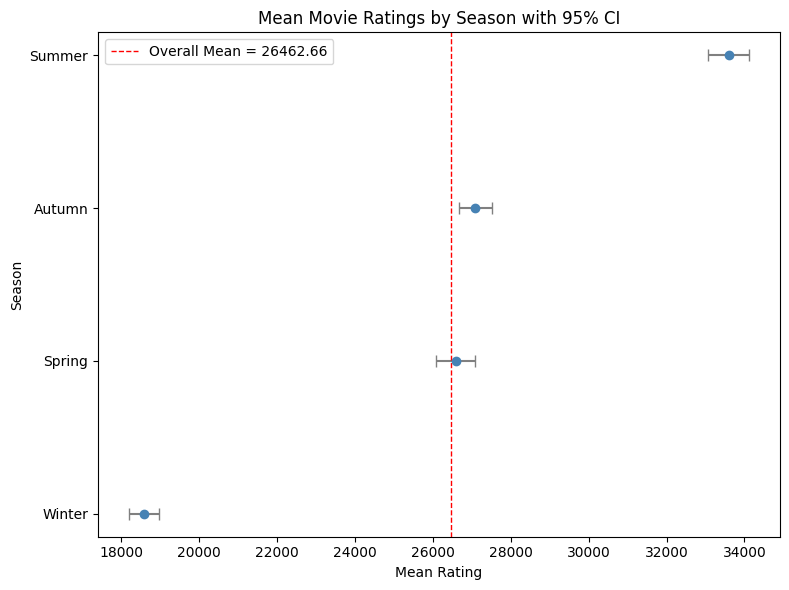

In [15]:
# Sort for plotting
plot_df = month_formula_ci.sort_values('mean_rating', ascending=True)

plt.figure(figsize=(8, 6))

# Plot the mean ratings as points with horizontal error bars
plt.errorbar(
    x=plot_df['mean_rating'],             # mean rating
    y=plot_df['season'],                  # season labels
    xerr=plot_df['margin_of_error'],      # half-length of CI
    fmt='o',                              # point marker
    color='steelblue',                    # point color
    ecolor='gray',                        # error bar color
    capsize=4,                            # cap size on error bars
    markersize=6                          # marker size
)

# Add a vertical line for overall mean rating
overall_mean = plot_df['mean_rating'].mean()
plt.axvline(
    overall_mean,
    color='red', linestyle='--', linewidth=1,
    label=f'Overall Mean = {overall_mean:.2f}'
)

# Labels and title
plt.xlabel('Mean Rating')
plt.ylabel('Season')
plt.title('Mean Movie Ratings by Season with 95% CI')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Confidence Interval (CI) using the formula mean +- t_critical * SE

# Group by genre and calculate statistics
month_formula_ci = (
    bikes
    .groupby('month')
    .agg(
        mean_rating=('bikes_hired', 'mean'),
        median_rating=('bikes_hired', 'median'),
        sd_rating=('bikes_hired', 'std'),
        count=('bikes_hired', 'size')
    )
    .reset_index()
)

# Calculate additional statistics for confidence intervals
month_formula_ci['t_critical'] = month_formula_ci['count'].apply(lambda n: stats.t.ppf(0.975, df=n-1))  # t-critical value
month_formula_ci['se_rating'] = month_formula_ci['sd_rating'] / np.sqrt(month_formula_ci['count'])  # Standard error
month_formula_ci['margin_of_error'] = month_formula_ci['t_critical'] * month_formula_ci['se_rating']  # Margin of error
month_formula_ci['rating_low'] = month_formula_ci['mean_rating'] - month_formula_ci['margin_of_error']  # Lower bound
month_formula_ci['rating_high'] = month_formula_ci['mean_rating'] + month_formula_ci['margin_of_error']  # Upper bound

# Sort by mean rating in descending order
month_formula_ci = month_formula_ci.sort_values(by='mean_rating', ascending=False)

# Display the result
month_formula_ci

C:\Users\balazs.szabo\AppData\Local\Temp\ipykernel_37808\1419881304.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('month')


,month,mean_rating,median_rating,sd_rating,count,t_critical,se_rating,margin_of_error,rating_low,rating_high
6,July,35887.263441,37927.0,8153.309280,372,1.966379,422.729394,831.246119,35056.017322,36718.509560
5,June,33631.316883,33705.0,8763.203130,385,1.966161,446.614186,878.115378,32753.201505,34509.432261
7,August,31594.632794,33274.0,9841.927397,433,1.965471,472.972847,929.614182,30665.018613,32524.246976
4,May,30670.665835,30267.0,8549.928955,401,1.965912,426.963077,839.371983,29831.293852,31510.037819
8,September,30545.927885,31784.0,8182.234411,416,1.965697,401.167047,788.572751,29757.355133,31334.500636
9,October,27507.046189,27984.0,6904.526087,433,1.965471,331.810348,652.163454,26854.882735,28159.209644
3,April,26231.071979,26197.0,7782.291281,389,1.966097,394.577831,775.778242,25455.293738,27006.850221
10,November,23230.837709,23667.0,6521.431036,419,1.965655,318.592754,626.243588,22604.594121,23857.081297
2,March,22834.987500,23349.0,7751.037745,400,1.965927,387.551887,761.898834,22073.088666,23596.886334
1,February,20335.369146,20629.0,6553.321059,363,1.966539,343.960153,676.410990,19658.958156,21011.780136


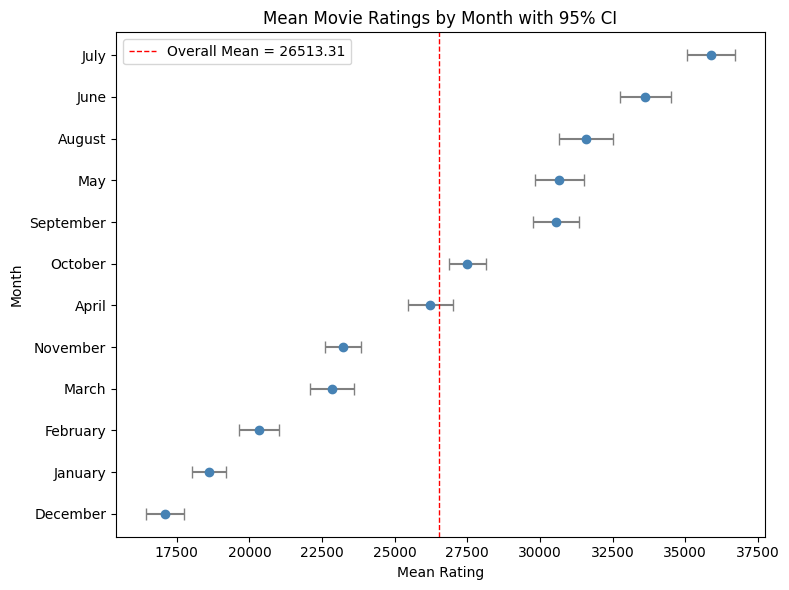

In [17]:
# Sort for plotting
plot_df = month_formula_ci.sort_values('mean_rating', ascending=True)

plt.figure(figsize=(8, 6))

# Plot the mean ratings as points with horizontal error bars
plt.errorbar(
    x=plot_df['mean_rating'],             # mean rating
    y=plot_df['month'],                   # month labels
    xerr=plot_df['margin_of_error'],      # half-length of CI
    fmt='o',                              # point marker
    color='steelblue',                    # point color
    ecolor='gray',                        # error bar color
    capsize=4,                            # cap size on error bars
    markersize=6                          # marker size
)

# Add a vertical line for overall mean rating
overall_mean = plot_df['mean_rating'].mean()
plt.axvline(
    overall_mean,
    color='red', linestyle='--', linewidth=1,
    label=f'Overall Mean = {overall_mean:.2f}'
)

# Labels and title
plt.xlabel('Mean Rating')
plt.ylabel('Month')
plt.title('Mean Movie Ratings by Month with 95% CI')
plt.legend()
plt.tight_layout()
plt.show()

**Regression Analysis**

What variables influence the number of bikes rented (y) and how? Build a regression model that best explains the variability in bikes rented.

**Interpret:**

Which predictors are significant?

What do the coefficients mean (in practical terms)?

How much of the variation in bike rentals is explained (R²)?

**Deliverables:**

Regression output table.

A short discussion of which factors matter most for predicting bike rentals.

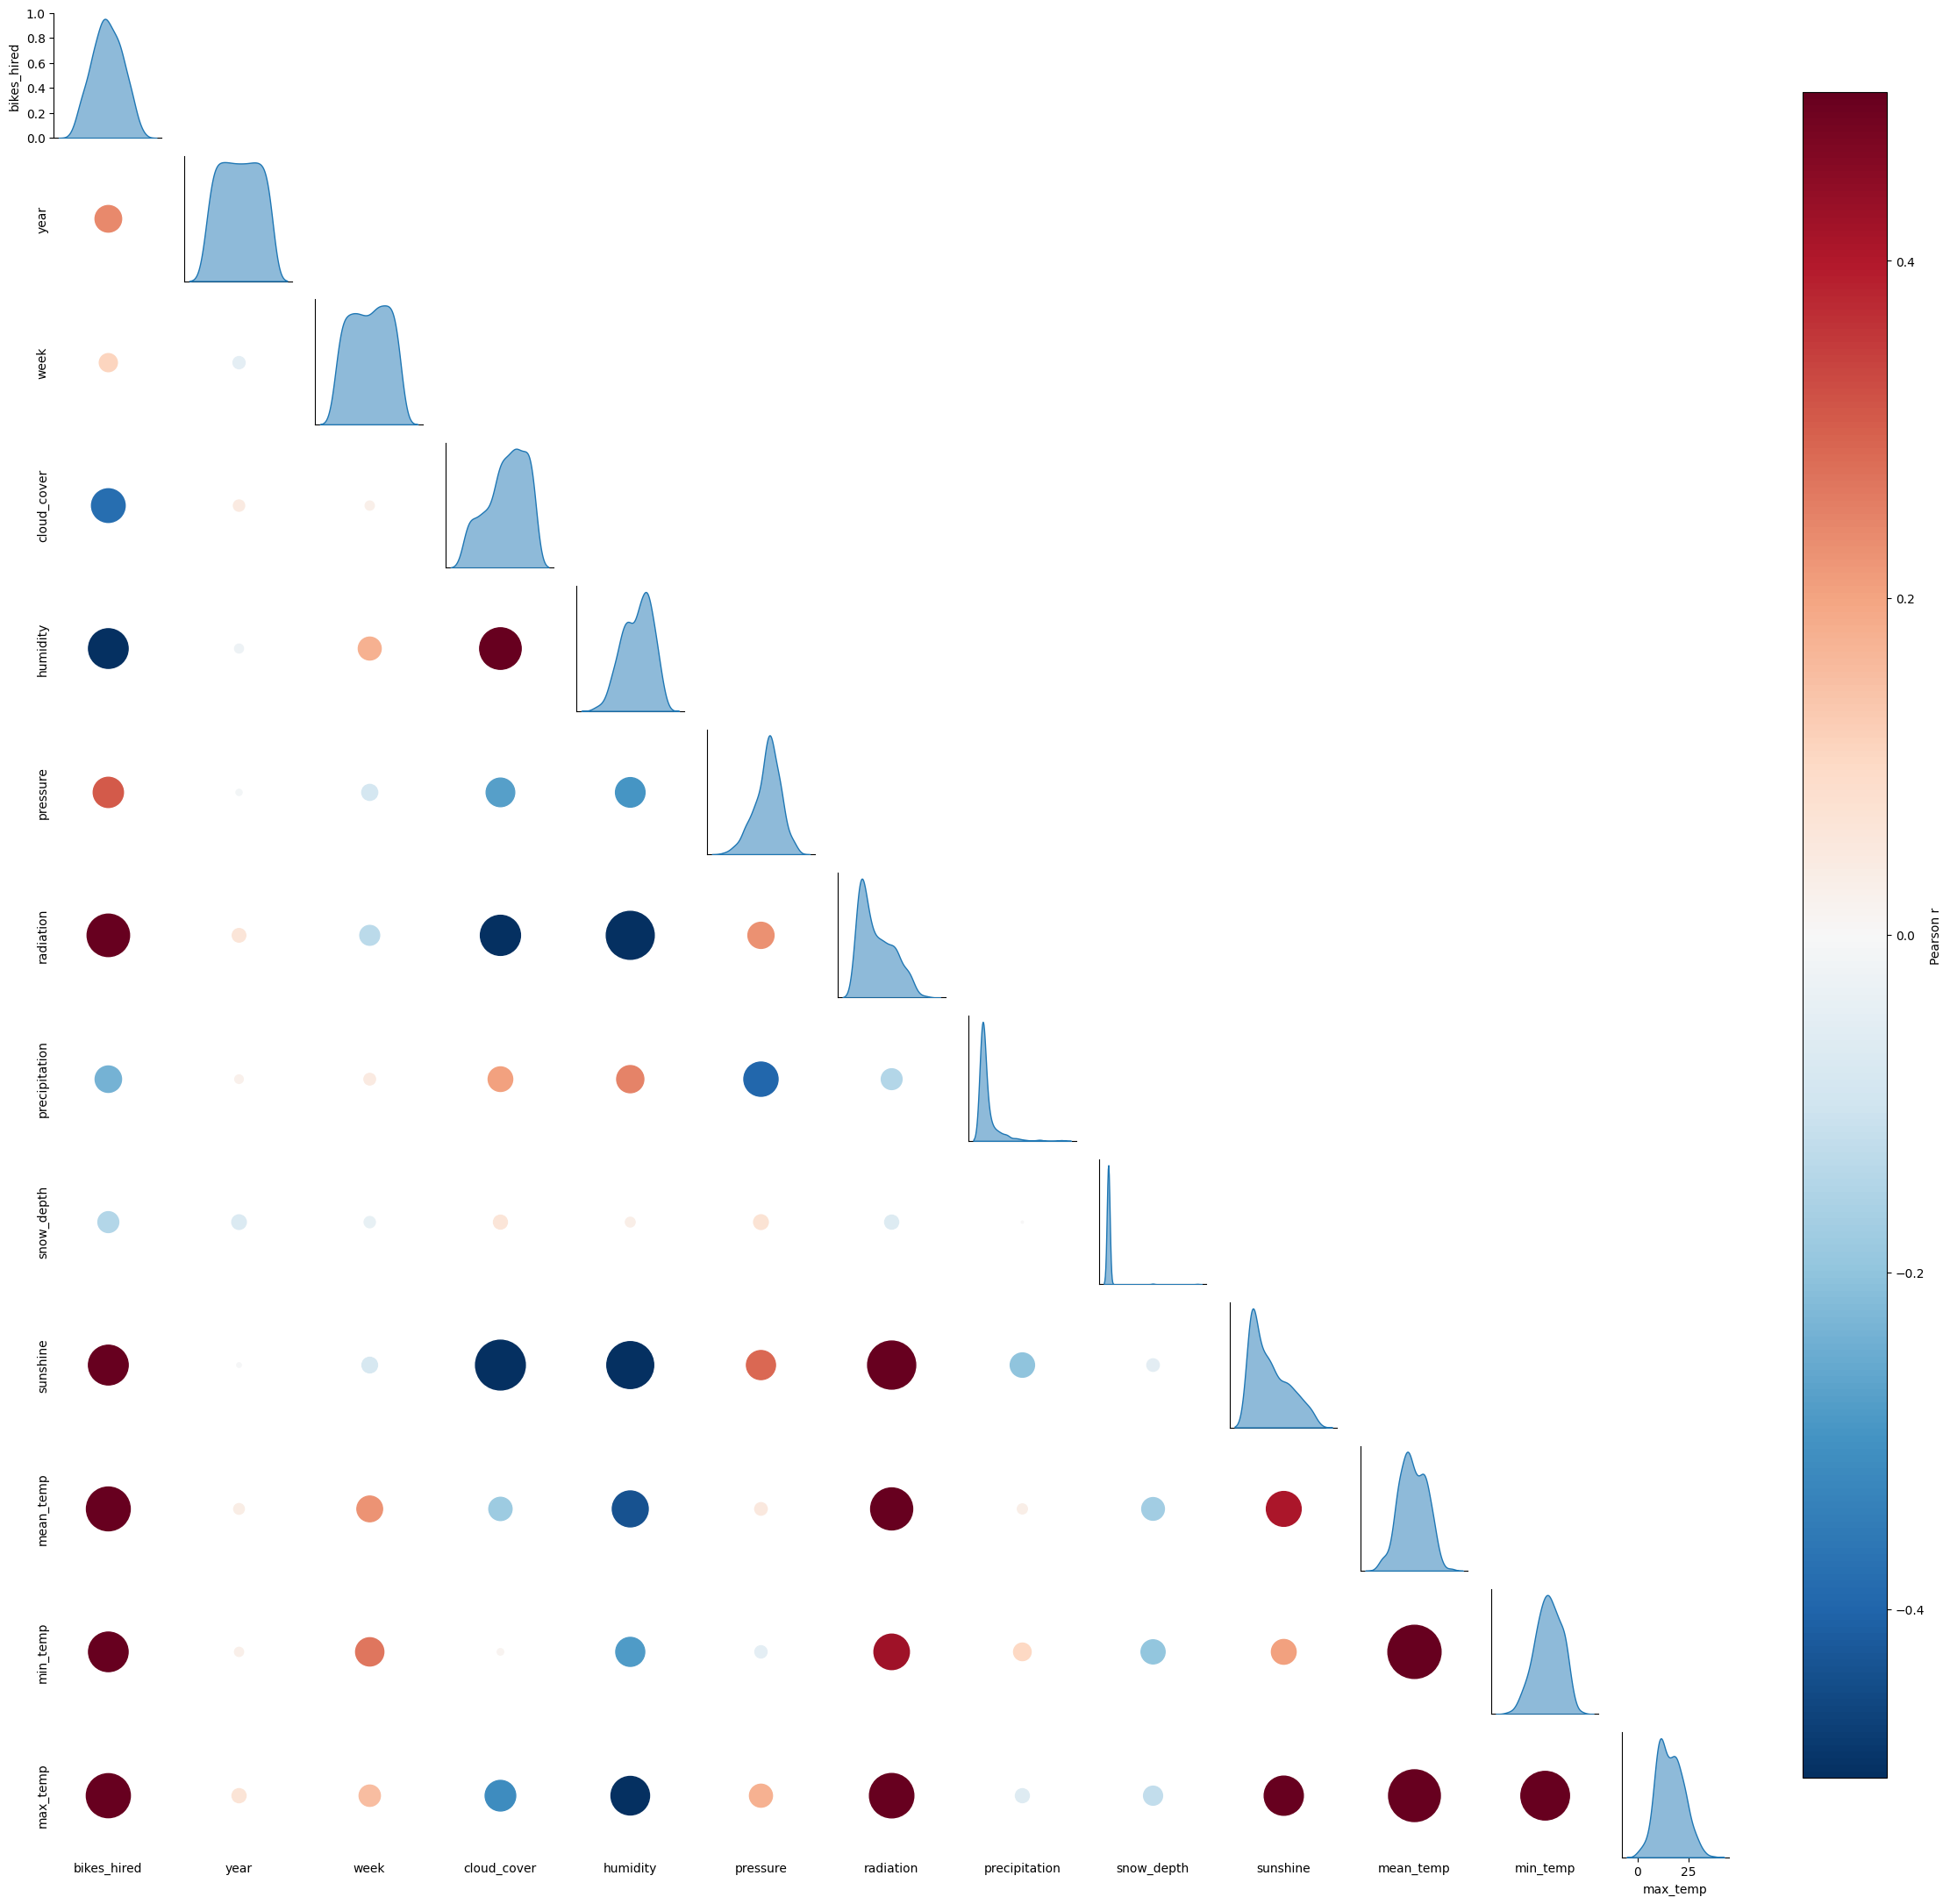

In [18]:
import seaborn as sns, matplotlib.pyplot as plt, numpy as np
from matplotlib.colors import Normalize

vars_order = ['bikes_hired','year','week','cloud_cover','humidity',
              'pressure','radiation','precipitation','snow_depth','sunshine',
              'mean_temp','min_temp','max_temp']
df_plot = bikes.iloc[::10, :].copy()


# bubble plot for correlations
def corr_dot(x, y, **kws):
    ax = plt.gca()
    x, y = np.asarray(x, float), np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    r = 0.0 if m.sum() < 2 else np.corrcoef(x[m], y[m])[0, 1]
    # scatter bubble in middle of cell
    ax.scatter(0.5, 0.5, s=2000*abs(r), c=[[r]],
               cmap=kws["cmap"], norm=kws["norm"],
               transform=ax.transAxes)
    # clean ticks & spines but KEEP axis for labels
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values(): spine.set_visible(False)

# hide upper triangle completely
def hide_axis(*args, **kwargs):
    plt.gca().set_visible(False)

g = sns.PairGrid(df_plot, vars=vars_order, diag_sharey=False, height=1.7)
# diagonal: filled KDE
g.map_diag(
    sns.kdeplot,
    fill=True, alpha=0.5
)
norm = Normalize(-0.5, 0.5)
g.map_lower(corr_dot, norm=norm, cmap="RdBu_r")
g.map_upper(hide_axis)

# labels for lower axes
for ax, lab in zip(g.axes[-1, :], vars_order): ax.set_xlabel(lab)
for ax, lab in zip(g.axes[:, 0], vars_order):  ax.set_ylabel(lab)

# colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap="RdBu_r"); sm.set_array([])
g.fig.colorbar(sm, ax=g.axes, fraction=0.046, pad=0.04, label="Pearson r")

plt.show()


In [19]:
# Multiple linear regression model with several predictors
model_clean = smf.ols('bikes_hired ~ mean_temp + sunshine + precipitation', data=bikes).fit()
print(model_clean.summary())



                            OLS Regression Results                            
Dep. Variable:            bikes_hired   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     1653.
Date:                Sat, 20 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:06:00   Log-Likelihood:                -49607.
No. Observations:                4842   AIC:                         9.922e+04
Df Residuals:                    4838   BIC:                         9.925e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.379e+04    237.504     58.051

## Deliverables
A knitted HTML, one person per group to submit